In [1]:
#%matplotlib inline
#%load_ext autoreload
#%autoreload 2

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Matlab-like way to work with matrices
import numpy as np
from numpy import genfromtxt
from tqdm.notebook import tqdm

# R-like way to work with dataframes
import pandas as pd

# Equivalent of brainstorm, EEGLAB, ...
import mne
from mne.io import read_raw_eeglab
from mne.viz import plot_topomap
from mne.channels import make_eeg_layout
from mne.preprocessing import compute_proj_eog
from mne.viz import circular_layout, plot_connectivity_circle
from mne.connectivity import spectral_connectivity

# Plotting libraries
import matplotlib.pylab as plt   # <= Similar to Matlab
import seaborn as sns            # <= Easy, nice-looking plotting  

from eegip.utils import loadmat # load_montage, 
from eegip.preprocessing import preprocess, channel_rejection, add_bad_segment_annot, \
    get_events, get_epochs, remove_rejected_ica_components, get_evoked
from eegip.dataset import DatasetMng
from eegip.path import get_path
from eegip import Analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols
from itertools import combinations

# Others...
from pathlib import Path
import re
import os
from glob import glob

from parse import parse
import xarray as xr
from scipy.stats import pearsonr

def mod_logit(x):
    return -np.log(2/(x+1)-1)

/home/christian/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def compute_scores(dat, time_agg_func="mean"):
    if time_agg_func == "mean":
        scores = np.abs(dat.sel(stat="mean")/dat.sel(stat="std")).mean("times").compute()
    elif time_agg_func == "max":
        scores = np.abs(dat.sel(stat="mean")/dat.sel(stat="std")).max("times").compute()
    elif time_agg_func is None:
        scores = np.abs(dat.sel(stat="mean")/dat.sel(stat="std"))
    else:
        raise RuntimeError
    scores = scores.assign_coords(template_age=[template_ages[template] for template in scores.coords["template_age"].values])
    scores = scores.sortby("template_age")
    return scores.rename({list(scores.variables.keys())[0]:"scores"})


def get_filtered_groups(scores, index, label_agg_func="mean"):
    arrays = []
    if label_agg_func == "mean":
        arr = scores.mean("labels")
    elif label_agg_func == "max":
        arr = scores.max("labels")
    elif label_agg_func is None:
        arr = scores
    else:
        raise RuntimeError
        
    for key_subject, key_event in zip(index["subject"], index["event"]):
        arrays.append(arr.sel(subject=[key_subject]).sel(event=[key_event]))

    return xr.combine_by_coords(arrays, coords="all", data_vars="all", fill_value=np.nan, join="outer")

In [5]:
dataset_name="eegip_london"

config =  {"atlas":
           {"vol_labels":
            ['Left-Amygdala',
             'Left-Caudate',
             'Left-Hippocampus',
             'Left-Pallidum',
             'Left-Putamen',
             'Left-Thalamus',
             'Right-Amygdala',
             'Right-Caudate',
             'Right-Hippocampus',
             'Right-Pallidum',
             'Right-Putamen',
             'Right-Thalamus'
            ]
           }
          }


template_ages = {"ANTS1-0Months3T":1, 
                 "ANTS2-0Months3T":2, 
                 "ANTS3-0Months3T":3, 
                 "ANTS4-5Months3T":4.5, 
                 "ANTS6-0Months3T":6, 
                 "ANTS7-5Months3T":7.5, 
                 "ANTS9-0Months3T":9, 
                 "ANTS10-5Months3T":10.5, 
                 "ANTS12-0Months3T":12, 
                 "ANTS15-0Months3T":15, 
                 "ANTS2-0Weeks3T":0.5, 
                 "ANTS18-0Months3T":18, 
                 "ANTS2-0Years3T":24,
                 "fsaverage":30,
                 "scalp": 36,
                 "ica": 42}

# Gathered computed sources

In [6]:
# Min values, to avoid creating inf values by division by 0. These can be due for example to 
# very small N.
min_std = 1e-8

#root = Path("/media/christian/seagate/template_check")
root = Path("/home/christian/template_check")
xr_list_sources = []
xr_list_scalp = []
xr_list_comp = []
for file_name in tqdm(list(root.glob("*.netcdf"))):   
    parse_result = parse("sub-s{}_ses-m{}_eeg_{}_{}_{}.netcdf", file_name.name)
    if not hasattr(parse_result, "fixed"):
        continue
    subject, age, event_str, template_age, stat = parse_result.fixed
    dat = xr.open_dataset(root / file_name) 
        
    if stat == "std":

        if np.min(dat.to_array().data) < min_std:
            dat = dat.where(dat['__xarray_dataarray_variable__'] > min_std, other=np.nan)

    dat = dat.expand_dims({"subject":[subject], 
                       #"age":[age], 
                       "event":[event_str],
                       "template_age":[template_age], 
                       "stat":[stat]})

    if template_age == "scalp":
        dat = dat.rename({"channels": "labels"})
        xr_list_scalp.append(dat)
    elif template_age == "ica":
        dat = dat.rename({"components": "labels"})
        xr_list_comp.append(dat)
    else:
        xr_list_sources.append(dat)

In [7]:
dat_scalp = xr.combine_by_coords(xr_list_scalp, coords="all", data_vars="all", fill_value=np.nan, join="outer")
dat_sources = xr.combine_by_coords(xr_list_sources, coords="all", data_vars="all", fill_value=np.nan, join="outer")
dat_comp = xr.combine_by_coords(xr_list_comp, coords="all", data_vars="all", fill_value=np.nan, join="outer")

In [8]:
# This is to reject incomplete (subject, age) pairs
scores_scalp = compute_scores(dat_scalp)
scores_sources = compute_scores(dat_sources)

tmp = xr.combine_by_coords([dat_scalp.to_array(name="con").mean("labels"),
                            dat_sources.to_array(name="con").mean("labels")],
                           coords="all", data_vars="all", fill_value=np.nan, join="outer")
tmp = tmp.mean("times").mean("stat").mean("template_age", skipna=False)

index = {dim:tmp["con"].coords[dim].values[indices] 
         for dim, indices 
         in zip(tmp["con"].dims, np.where(np.logical_not(np.isnan(tmp["con"]))))}

/home/christian/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/christian/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/christian/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:682: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/christian/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:682: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/christian/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Computing correlation between time series from different templates

In [9]:
# This is to reject incomplete (subject, age) pairs
tmp = dat_sources.mean("labels").mean("times").mean("stat").mean("template_age", skipna=False).to_array().squeeze()

index = {dim:tmp.coords[dim].values[indices] 
         for dim, indices 
         in zip(tmp.dims, np.where(np.logical_not(np.isnan(tmp))))}

dat_lst = []
for event in np.unique(index["event"]):
    sel_subjects = index["subject"][np.where(index["event"] == event)]
    dat = dat_sources.sel(event=[event]).sel(subject=sel_subjects).sel(stat="mean")
    dat_lst.append(dat)
dat = xr.combine_by_coords(dat_lst, coords="all", data_vars="all", fill_value=np.nan, join="outer")

In [10]:
corr_lst = []
for template_pair in combinations(dat.template_age.data, 2):

    dat1 = dat.sel(template_age=template_pair[0]).reset_coords()
    dat2 = dat.sel(template_age=template_pair[1]).reset_coords()

    s1 = dat1.std("times")
    s2 = dat2.std("times")
    mu1 = dat1.mean("times")
    mu2 = dat2.mean("times")

    (dat1 - mu1)*(dat2 - mu2)
    corr = ((dat1 - mu1)*(dat2 - mu2)).mean("times")/(s1*s2)
    
    corr_lst.append(corr.expand_dims({"template1":[template_pair[0]], 
                                      "template2":[template_pair[1]]}))
    
corr = xr.combine_by_coords(corr_lst, coords="all", data_vars="all", 
                            fill_value=np.nan, join="outer")

/home/christian/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [11]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 6}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
/home/christian/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


-0.692205515879741 0.47914847621433837 1.1171441067141967e-12 78


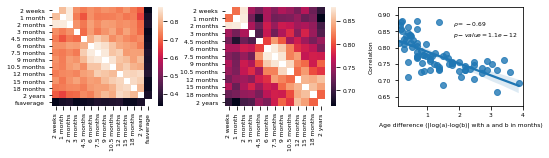

In [12]:
mean_eve_sub_lbl = corr.mean("event").mean("subject").mean("labels").to_array(name="corr").to_dataframe().reset_index().drop(columns=["variable"]) #.pivot_table(index="template1", columns="template2")
map_ = pd.concat([mean_eve_sub_lbl.dropna(), mean_eve_sub_lbl.dropna().rename(columns={"template1":"template2", "template2":"template1"})])\
         .reset_index().drop(columns=["index"]).pivot_table(index="template1", columns="template2", values="corr")

template_order = ["ANTS2-0Weeks3T",
                  "ANTS1-0Months3T", 
                  "ANTS2-0Months3T", 
                  "ANTS3-0Months3T", 
                  "ANTS4-5Months3T", 
                  "ANTS6-0Months3T", 
                  "ANTS7-5Months3T", 
                  "ANTS9-0Months3T", 
                  "ANTS10-5Months3T", 
                  "ANTS12-0Months3T", 
                  "ANTS15-0Months3T",                   
                  "ANTS18-0Months3T", 
                  "ANTS2-0Years3T",
                  "fsaverage"]

ages = ["2 weeks", "1 month", "2 months", "3 months", "4.5 months", "6 months", "7.5 months", 
        "9 months", "10.5 months", "12 months", "15 months", "18 months", "2 years", "fsaverage"]

fig_heatmaps_time, axes_heatmaps_time = plt.subplots(1, 3, figsize=(7.45, 2.0))

# First heatmap
sns.heatmap(map_.loc[template_order, template_order], ax=axes_heatmaps_time[0])
axes_heatmaps_time[0].axes.set_xticklabels(ages)
axes_heatmaps_time[0].axes.set_yticklabels(ages)
axes_heatmaps_time[0].axes.set_xlabel("")
axes_heatmaps_time[0].axes.set_ylabel("");

# Second heatmap
sns.heatmap(map_.loc[template_order[:-1], template_order[:-1]], ax=axes_heatmaps_time[1])
axes_heatmaps_time[1].axes.set_xticklabels(ages[:-1])
axes_heatmaps_time[1].axes.set_yticklabels(ages[:-1])
axes_heatmaps_time[1].axes.set_xlabel("")
axes_heatmaps_time[1].axes.set_ylabel("");

# Regression plot
tmp2 = mean_eve_sub_lbl.dropna()
tmp2.loc[tmp2["template1"] == "fsaverage", "template1"] = np.nan
tmp2.loc[tmp2["template2"] == "fsaverage", "template2"] = np.nan
tmp2 = tmp2.dropna()
tmp2["age1"] = [template_ages[template] for template in tmp2["template1"]]
tmp2["age2"] = [template_ages[template] for template in tmp2["template2"]]
tmp2["age_diff"] = np.abs(np.log(tmp2["age1"]) - np.log(tmp2["age2"]))

assert(tmp2.shape[0] == (13*12)/2)

sns.regplot(x="age_diff", y="corr", data=tmp2, ax=axes_heatmaps_time[2]);

rho, pval = pearsonr(tmp2["age_diff"], tmp2["corr"])
print(rho, rho**2, pval/2, tmp2.shape[0])

axes_heatmaps_time[2].set_xlabel("Age difference (|log(a)-log(b)| with a and b in months)")
axes_heatmaps_time[2].set_ylabel("Correlation")
#axes_heatmaps_time[2].set_ylim(-0.7, -0.12)
axes_heatmaps_time[2].set_xlim(0.1, 4.0)
axes_heatmaps_time[2].text(1.8, 0.835, "$\\rho={:.2}$\n$p-value={:.2}$".format(rho, pval/2));

fig_heatmaps_time.tight_layout(pad=0)
fig_heatmaps_time.savefig("functional_validation_ac.png", dpi=300)

# Show the effect of including labels in the averaging

/home/christian/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/christian/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dime

             sum_sq     df           F        PR(>F)
label     27.213347   79.0    3.611534  4.488011e-21
age       12.581894    1.0  131.911570  1.080591e-28
Residual  91.184502  956.0         NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                   corr   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     5.216
Date:                Fri, 23 Oct 2020   Prob (F-statistic):           3.95e-37
Time:                        14:09:55   Log-Likelihood:                -210.86
No. Observations:                1037   AIC:                             583.7
Df Residuals:                     956   BIC:                             984.2
Df Model:                          80                                         
Covariance Type:            nonrobust                                        

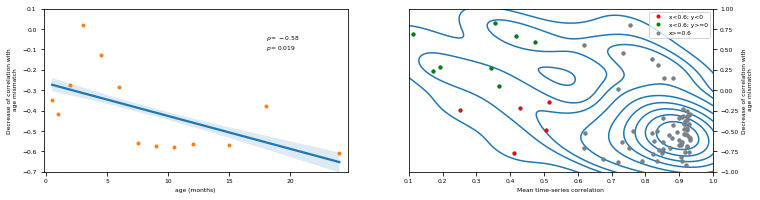

In [13]:
pvals = []
rhos = []
labels = []
threshold = 0.6

# USING LOGIT
#tmp = mod_logit(corr).mean("event").mean("subject").to_array(name="corr")
tmp = corr.mean("event").mean("subject").to_array(name="corr")
tmp = tmp.to_dataframe().reset_index().drop(columns=["variable"])
tmp2 = tmp.dropna()
tmp2.loc[tmp2["template1"] == "fsaverage", "template1"] = np.nan
tmp2.loc[tmp2["template2"] == "fsaverage", "template2"] = np.nan
tmp2 = tmp2.dropna()
tmp2["age1"] = [template_ages[template] for template in tmp2["template1"]]
tmp2["age2"] = [template_ages[template] for template in tmp2["template2"]]
tmp2["age_diff"] = np.abs(np.log(tmp2["age1"]) - np.log(tmp2["age2"]))

dfs = []
for label, group_df in tqdm(tmp2.groupby(["labels"])):
    correls = []
    for template in template_order[:-1]:
        correls.append(group_df.loc[((group_df["template1"] == template) |  (group_df["template2"] == template)),
                                               ["age_diff", "corr"]].corr(method="spearman").values[0, 1])
        
    df = pd.DataFrame(dict(corr=correls, template=template_order[:-1]))
    df["label"] = label
    
    try:
        rho, pval = pearsonr(df.index, df["corr"])
        labels.append(label)
        pvals.append(pval)
        rhos.append(rho)        
    except:
        pass   
    
    dfs.append(df)    
    
df = pd.concat(dfs)    
df["age"] = [template_ages[template] for template in df["template"]]

age_coor_reg_per_regions = pd.DataFrame({"pvals":pvals, "rhos": rhos, "labels": labels})
x = df.groupby('age').mean()

fig_5_2, axes_5_2 = plt.subplots(1, 2, figsize=(12, 3)) #, sharey=True)

rho, p = pearsonr(x.index, x["corr"])
sns.regplot(x="age", y="corr", data=df, scatter=True, fit_reg=True, ax=axes_5_2[0], marker=".", scatter_kws={"color": "white"})
axes_5_2[0].plot(x.index, x["corr"], ".")
axes_5_2[0].set_xlabel("age (months)")
axes_5_2[0].set_ylabel("Decrease of correlation with\n age mismatch")
axes_5_2[0].text(18, -0.10, "$\\rho={:.2}$\n$p={:.2}$".format(rho, p/2))
axes_5_2[0].set_ylim(-0.7, 0.1)
axes_5_2[0].set_xlim(-0.2, 24.7)

tmp3  = tmp2.copy().drop(columns="age2").rename(columns={"age1": "age"})
tmp4  = tmp2.copy().drop(columns="age1").rename(columns={"age2": "age"})

sorted_labels = pd.pivot_table(columns="labels", index="age", values="corr", 
                           data=pd.concat([tmp3, tmp4])).dropna(axis=1).mean(0).sort_values().index

x = pd.pivot_table(columns="labels", index="age", values="corr", 
                 data=pd.concat([tmp3, tmp4])).dropna(axis=1).mean(0)[sorted_labels]
y = age_coor_reg_per_regions.set_index("labels")["rhos"][sorted_labels]
axes_5_2[1].plot(x, y, ".", color=axes_5_2[0].lines[0].get_color())
axes_5_2[1].plot(x[(x<threshold)&(y < 0)], y[(x<threshold)&(y < 0)], ".", color="red", label="x<0.6; y<0")
axes_5_2[1].plot(x[(x<threshold)&(y >= 0)], y[(x<threshold)&(y >= 0)], ".", color="green", label="x<0.6; y>=0")
axes_5_2[1].plot(x[(x>=threshold)], y[(x>=threshold)], ".", color="grey", label="x>=0.6")
axes_5_2[1].legend()

red_labels = sorted_labels[(x<threshold)&(y < 0)]
green_labels = sorted_labels[(x<threshold)&(y >= 0)]


sns.kdeplot(x, y, ax=axes_5_2[1], color=axes_5_2[0].lines[0].get_color())

axes_5_2[1].yaxis.tick_right()                 
axes_5_2[1].yaxis.set_label_position("right")
axes_5_2[1].set_ylabel("Decrease of correlation with\n age mismatch")
axes_5_2[1].set_xlabel("Mean time-series correlation")
axes_5_2[1].set_ylim(-1, 1)
axes_5_2[1].set_xlim(0.1, 1);


#lm = ols('corr ~ N + age + label', data=df).fit()
lm = ols('corr ~ age + label', data=df).fit()
table = sm.stats.anova_lm(lm, typ=2) # Type 2 ANOVA DataFrame
print(table)
print(lm.summary())

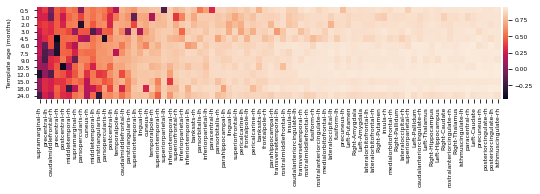

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(7.45, 2.5))
ax_heatmap = sns.heatmap(pd.pivot_table(columns="labels", index="age", values="corr", 
                         data=pd.concat([tmp3, tmp4])).dropna(axis=1)[sorted_labels], ax=ax,
                         xticklabels=1, yticklabels=1)

gs = ax_heatmap.get_gridspec()
gs._wspace = 0.01
gs.set_width_ratios([0.92, 0.08])
ax.set_xlabel("")
ax.set_ylabel("Template age (months)")


(pd.concat([tmp3, tmp4])).dropna(axis=1).mean(0)
#plt.tight_layout()
ax.set_xlabel("");


fig.tight_layout(pad=0)
fig.savefig("functional_validation_g.png", dpi=300)

In [15]:
activations = pd.pivot_table(columns="labels", index="age", values="corr", 
                           data=pd.concat([tmp3, tmp4])).dropna(axis=1)[[x.get_text() for x in ax_heatmap.get_xticklabels()]].mean(0)

In [16]:
from matplotlib import cm
import matplotlib.pylab as plt

def map_activation_to_colors(activations, cmap_name):
    x = (activations - np.min(activations))/(np.max(activations) - np.min(activations))
    return cm.get_cmap(plt.get_cmap(cmap_name))(x)

colors = {label: ([1, 0, 0, 1] if act < threshold else [0.8, 0.8, 0.8, 1.0]) for label, act in activations.items()}

Skipping  Thalamus-Proper-lh
Skipping  Cerebellum-Cortex-lh
Skipping  Brain-Stem
Skipping  Thalamus-Proper-rh
Skipping  Cerebellum-Cortex-rh


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


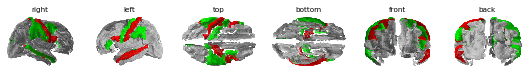

In [17]:
from eegip.atlas import Atlas
atlas = Atlas(subjects_dir="/usr/local/freesurfer/subjects", fs_subject="ANTS12-0Months3T")

'''
labels_vol = ['Left-Amygdala',
             'Left-Caudate',
             'Left-Hippocampus',
             'Left-Pallidum',
             'Left-Putamen',
             'Left-Thalamus',
             'Right-Amygdala',
             'Right-Caudate',
             'Right-Hippocampus',
             'Right-Pallidum',
             'Right-Putamen',
             'Right-Thalamus'
            ]
atlas.build_bem(labels_vol=labels_vol)
atlas.mesh_atlas_pacels()    
atlas.compute_pacels_centers_of_masse()
'''

colors.update({label:[1, 0, 0] for label in red_labels})
colors.update({label:[0, 1, 0] for label in green_labels})

fig, axes = atlas.plot_brain_region_strip(regions=list(colors.keys()), colors=colors, 
                              figsize=(7.45, 1.5),  views=None, transparency=1.0, hemi_labels=[])

fig.tight_layout(pad=0)
fig.savefig("functional_validation_h.png", dpi=300)

In [18]:
from IPython.display import Image
Image(url="https://ars.els-cdn.com/content/image/1-s2.0-S0896627315008156-gr1.jpg")
# important maturation around the central fissure from 3w to 14w; see fig1.b https://www.sciencedirect.com/science/article/pii/S0896627315008156

We might be able to use Richards database to compute similar maturation index using T1/T2 ratio (https://www.frontiersin.org/articles/10.3389/fnhum.2014.00671/full)

## Correlations across labels

In [19]:
# This is to reject incomplete (subject, age) pairs
tmp = dat_sources.mean("labels").mean("times").mean("stat").mean("template_age", skipna=False).to_array().squeeze()

index = {dim:tmp.coords[dim].values[indices] 
         for dim, indices 
         in zip(tmp.dims, np.where(np.logical_not(np.isnan(tmp))))}

dat_lst = []
for event in np.unique(index["event"]):
    sel_subjects = index["subject"][np.where(index["event"] == event)]
    dat = dat_sources.sel(event=[event]).sel(subject=sel_subjects).sel(stat="mean")
    dat_lst.append(dat)
dat = xr.combine_by_coords(dat_lst, coords="all", data_vars="all", fill_value=np.nan, join="outer")

/home/christian/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [20]:
corr_lst = []
for template_pair in combinations(dat.template_age.data, 2):

    dat1 = dat.sel(template_age=template_pair[0]).reset_coords()
    dat2 = dat.sel(template_age=template_pair[1]).reset_coords()

    s1 = dat1.std("labels")
    s2 = dat2.std("labels")
    mu1 = dat1.mean("labels")
    mu2 = dat2.mean("labels")

    (dat1 - mu1)*(dat2 - mu2)
    corr_tmp = ((dat1 - mu1)*(dat2 - mu2)).mean("labels")/(s1*s2)
    
    corr_lst.append(corr_tmp.expand_dims({"template1":[template_pair[0]], 
                                      "template2":[template_pair[1]]}))

/home/christian/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [21]:
corr_labels = xr.combine_by_coords(corr_lst, coords="all", data_vars="all", fill_value=np.nan, join="outer")

/home/christian/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


-0.6384920132026587 0.4076720509235841 1.597831595488196e-10 78


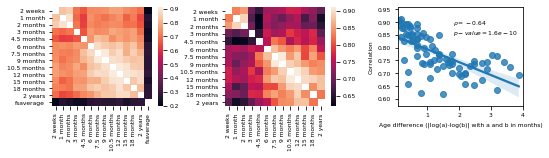

In [22]:
mean_eve_sub_time = corr_labels.mean("event").mean("subject").mean("times").to_array(name="corr").to_dataframe().reset_index().drop(columns=["variable"]) #.pivot_table(index="template1", columns="template2")
map_ = pd.concat([mean_eve_sub_time.dropna(), mean_eve_sub_time.dropna().rename(columns={"template1":"template2", "template2":"template1"})])\
         .reset_index().drop(columns=["index"]).pivot_table(index="template1", columns="template2", values="corr")

fig_heatmaps_labels, axes_heatmaps_labels = plt.subplots(1, 3, figsize=(7.45, 2.0))

# First heatmap
sns.heatmap(map_.loc[template_order, template_order], ax=axes_heatmaps_labels[0])
axes_heatmaps_labels[0].axes.set_xticklabels(ages)
axes_heatmaps_labels[0].axes.set_yticklabels(ages)
axes_heatmaps_labels[0].axes.set_xlabel("")
axes_heatmaps_labels[0].axes.set_ylabel("");

# Second heatmap
sns.heatmap(map_.loc[template_order[:-1], template_order[:-1]], ax=axes_heatmaps_labels[1])
axes_heatmaps_labels[1].axes.set_xticklabels(ages[:-1])
axes_heatmaps_labels[1].axes.set_yticklabels(ages[:-1])
axes_heatmaps_labels[1].axes.set_xlabel("")
axes_heatmaps_labels[1].axes.set_ylabel("");


# Regression plot
tmp2 = mean_eve_sub_time.dropna()
tmp2.loc[tmp2["template1"] == "fsaverage", "template1"] = np.nan
tmp2.loc[tmp2["template2"] == "fsaverage", "template2"] = np.nan
tmp2 = tmp2.dropna()
tmp2["age1"] = [template_ages[template] for template in tmp2["template1"]]
tmp2["age2"] = [template_ages[template] for template in tmp2["template2"]]
tmp2["age_diff"] = np.abs(np.log(tmp2["age1"]) - np.log(tmp2["age2"]))

assert(tmp2.shape[0] == (13*12)/2)

sns.regplot(x="age_diff", y="corr", data=tmp2, ax=axes_heatmaps_labels[2]) #, marker=None, scatter_kws={"color":colors, "marker":marker})
rho, pval = pearsonr(tmp2["age_diff"], tmp2["corr"])
print(rho, rho**2, pval/2, tmp2.shape[0])

plt.xlabel("Age difference (|log(a)-log(b)| with a and b in months)")
plt.ylabel("Correlation")

axes_heatmaps_labels[2].set_xlabel("Age difference (|log(a)-log(b)| with a and b in months)")
axes_heatmaps_labels[2].set_ylabel("Correlation")
#axes_heatmaps_time[2].set_ylim(-0.7, -0.12)
axes_heatmaps_labels[2].set_xlim(0.1, 4.0)
axes_heatmaps_labels[2].text(1.8, 0.85, "$\\rho={:.2}$\n$p-value={:.2}$".format(rho, pval/2));

fig_heatmaps_labels.tight_layout(pad=0)
fig_heatmaps_labels.savefig("functional_validation_df.png", dpi=300)

In [23]:
tmp = corr.mean("subject").mean("event").to_array(name="corr").to_dataframe().reset_index().drop(columns=["variable"])
tmp2 = tmp.dropna()
tmp2.loc[tmp2["template1"] == "fsaverage", "template1"] = np.nan
tmp2.loc[tmp2["template2"] == "fsaverage", "template2"] = np.nan
tmp2 = tmp2.dropna()
tmp2["age1"] = [template_ages[template] for template in tmp2["template1"]]
tmp2["age2"] = [template_ages[template] for template in tmp2["template2"]]
tmp2["age_diff"] = np.abs(np.log(tmp2["age1"]) - np.log(tmp2["age2"]))

dfs = []
for labels, group_df in tqdm(tmp2.groupby(["labels"])):
    correls = []
    for template in template_order[:-1]:
        correls.append(group_df.loc[((group_df["template1"] == template) |  (group_df["template2"] == template)),
                                               ["age_diff", "corr"]].corr().values[0, 1])
        
    df = pd.DataFrame(dict(corr=correls, template=template_order[:-1]))
    df["labels"] = labels
    dfs.append(df)    
    
df = pd.concat(dfs)    
df["age"] = [template_ages[template] for template in df["template"]]

/home/christian/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/christian/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


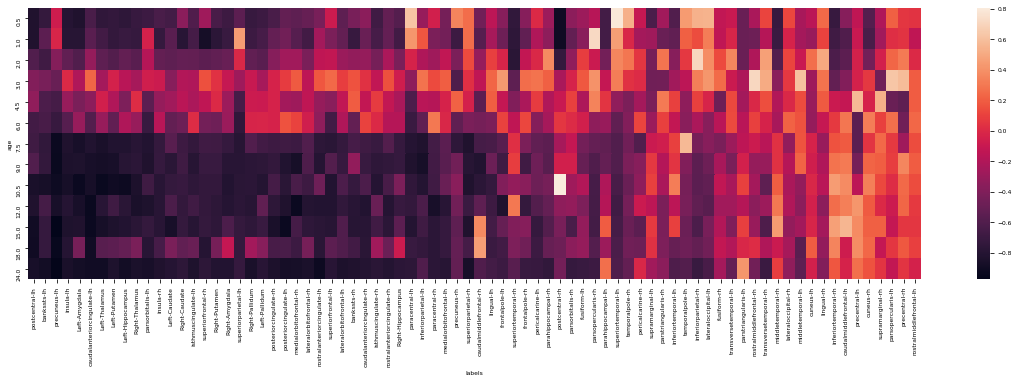

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
order = pd.pivot_table(columns="labels", index="age", values="corr", data=df).dropna(axis=1).mean(0).sort_values().index
sns.heatmap(pd.pivot_table(columns="labels", index="age", values="corr", data=df).dropna(axis=1)[order], ax=ax)

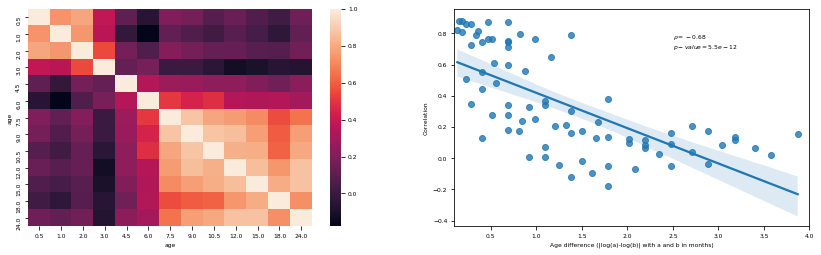

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Heatmap
sns.heatmap(pd.pivot_table(columns="labels", index="age", values="corr", data=df).dropna(axis=1).T.corr(), ax=axes[0])

# Regression plot
x = pd.pivot_table(columns="labels", index="age", values="corr", data=df).dropna(axis=1).T.corr()
x[:] = (x + np.triu(np.ones_like(x)*np.nan))
x = x.reset_index().rename(columns={"age": "age2"}).melt(id_vars="age2").rename(columns={"value": "corr"}).dropna().astype(float)
x["age_diff"] = np.abs(np.log(x["age"]) - np.log(x["age2"]))

sns.regplot(x="age_diff", y="corr", data=x, ax=axes[1]) #, marker=None, scatter_kws={"color":colors, "marker":marker})
rho, pval = pearsonr(x["age_diff"], x["corr"])
axes[1].set_xlabel("Age difference (|log(a)-log(b)| with a and b in months)")
axes[1].set_ylabel("Correlation")
axes[1].set_xlim(0.1, 4.0)
axes[1].text(2.5, 0.7, "$\\rho={:.2}$\n$p-value={:.2}$".format(rho, pval/2));

## Correlations across subjects

In [26]:
#tmp = corr.mean("event").mean("subject").mean("labels").to_array(name="corr").to_dataframe().reset_index().drop(columns=["variable"])
tmp = corr.mean("event").mean("labels").to_array(name="corr").to_dataframe().reset_index().drop(columns=["variable"])
tmp2 = tmp.dropna()
tmp2.loc[tmp2["template1"] == "fsaverage", "template1"] = np.nan
tmp2.loc[tmp2["template2"] == "fsaverage", "template2"] = np.nan
tmp2 = tmp2.dropna()
tmp2["age1"] = [template_ages[template] for template in tmp2["template1"]]
tmp2["age2"] = [template_ages[template] for template in tmp2["template2"]]
tmp2["age_diff"] = np.abs(np.log(tmp2["age1"]) - np.log(tmp2["age2"]))

dfs = []
for subject, group_df in tqdm(tmp2.groupby(["subject"])):
    correls = []
    for template in template_order[:-1]:
        correls.append(group_df.loc[((group_df["template1"] == template) |  (group_df["template2"] == template)),
                                               ["age_diff", "corr"]].corr().values[0, 1])
        
    df = pd.DataFrame(dict(corr=correls, template=template_order[:-1]))
    df["event"] = event
    df["subject"] = subject
    df["label"] = label
    dfs.append(df)    
    
df = pd.concat(dfs)    
df["age"] = [template_ages[template] for template in df["template"]]

/home/christian/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/christian/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


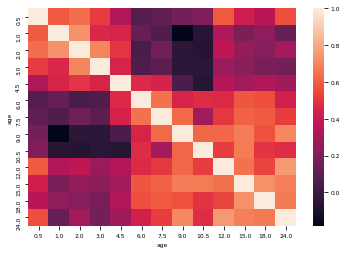

In [27]:
sns.heatmap(pd.pivot_table(columns="subject", index="age", values="corr", data=df).dropna(axis=1).T.corr())

Text(0, 0.5, 'Correlation')

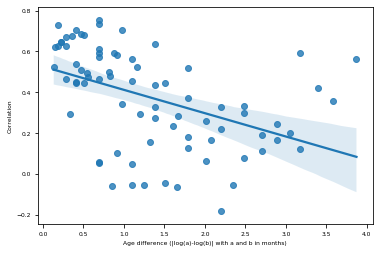

In [28]:
x = pd.pivot_table(columns="subject", index="age", values="corr", data=df).dropna(axis=1).T.corr()
x[:] = np.tril(x) + np.triu(np.ones_like(x)*np.nan)
tmp = x.reset_index().rename(columns={"age": "age2"}).melt(id_vars="age2").dropna()
tmp["age_diff"] = np.abs(np.log(tmp["age"].astype(float)) - np.log(tmp["age2"].astype(float)))


sns.regplot(x="age_diff", y="value", data=tmp) #, marker=None, scatter_kws={"color":colors, "marker":marker})

plt.xlabel("Age difference (|log(a)-log(b)| with a and b in months)")
plt.ylabel("Correlation")

In [29]:
correl = tmp[["age_diff", "value"]].corr().values[0, 1]
print(pearsonr(tmp["age_diff"], tmp["value"]), correl**2, tmp.shape[0])

(-0.45121328425925694, 3.382536047752744e-05) 0.2035934278920247 78
